# Leven at Newby Bridge using HBV model in eWaterCycle

In [27]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#general python
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## set up paths

In [3]:
forcing_path = Path.home() / "Forcing"
forcing_path.mkdir(exist_ok=True)

# choose region
We have to pick a region where to run the model, in order to generate forcing inputs for the model. Of course, we choose the region where we are organising this workshop: "Leven at Newby Bridge"

In [4]:
camelsgb_id = "camelsgb_73010"

In [5]:
forcing_path_basin = forcing_path / camelsgb_id 
forcing_path_basin.mkdir(exist_ok=True)

forcing_path_caravan = forcing_path_basin / "caravan"
forcing_path_caravan.mkdir(exist_ok=True)

forcing_path_era5 = forcing_path_basin / "ERA5"
forcing_path_era5.mkdir(exist_ok=True)

## add parameter info

Array of initial storage terms - we keep these constant for now: <br>
                Si,  Su, Sf, Ss


In [6]:
s_0 = np.array([0,  100,  0,  5, 0])

Array of parameters min/max bounds as a reference: <br>
Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks

In [7]:
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

Set initial as mean of max,min

In [9]:
#load calibration constants
par_0 = np.loadtxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", delimiter = ",")
print(par_0)

[5.50338828e+00 9.83551656e-01 3.81692295e+02 7.82133459e-01
 1.86158033e-01 2.77521065e+00 9.58927813e-02 1.75667897e-03
 4.57787948e+00]

Specify start and end date

In [10]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"



## Forcing

In [11]:
#from ewatercycle_HBV.forcing import HBVForcing

we use camels forcing as an example, which is fully integrated [Newman, 2014](https://gdex.ucar.edu/dataset/camels.html). The seperate text file is hosted [here](https://github.com/Daafip/Msc-Thesis-Notebooks/blob/4735392c4f15af29f433e87491d65668e89663b5/Forcing/01620500_lump_cida_forcing_leap.txt) for easy access without having to download the whole dataset (13gb). 

In [12]:
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(start_time = experiment_start_date,
                                                               end_time = experiment_end_date,
                                                               directory = forcing_path,
                                                               basin_id = camelsgb_id,
                                                                 )


In [13]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/Forcing'),
    shape=PosixPath('/home/rhut/Forcing/camelsgb_73010.shp'),
    filenames={
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc',
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc'
    }
)

<Axes: xlabel='time'>

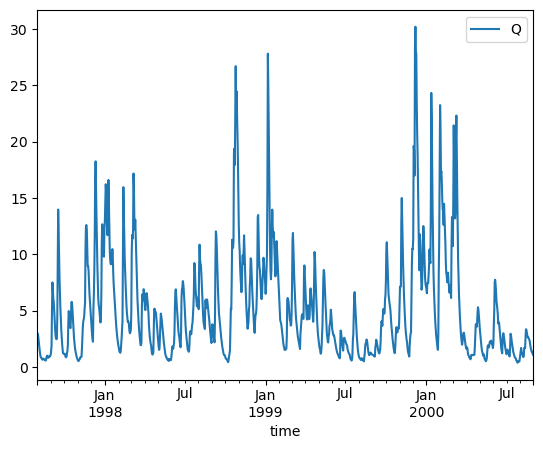

In [28]:
ds = xr.open_dataset(camelsgb_forcing['Q'])
caravan_observation_df = ds['Q'].to_dataframe().reset_index()
caravan_observation_df = caravan_observation_df.set_index('time')
caravan_observation_df = caravan_observation_df[['Q']] #NOTE: mm/day
caravan_observation_df.plot()

In [15]:
# Option one: generate forcing
#ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=camelsgb_forcing.shape,
#    directory=forcing_path_era5
#)

#option two: already done and just load
load_location = forcing_path_era5 / "work" / "diagnostic" / "script"
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [16]:
#camels_forcing = HBVForcing(start_time = experiment_start_date,
#                          end_time = experiment_end_date,
#                          directory = forcing_path,
#                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
#                          alpha= alpha
#                          )

## Setting up the model

In [17]:
model = ewatercycle.models.HBV(forcing = ERA5_forcing)

In [20]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
    initial_storage=','.join([str(s) for s in s_0]),
           )

In [21]:
model.initialize(config_file)

## Running model

In [22]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

After running the model: finalize to shut everything down

In [23]:
model.finalize()

## Process results

In [30]:
modelOutput = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

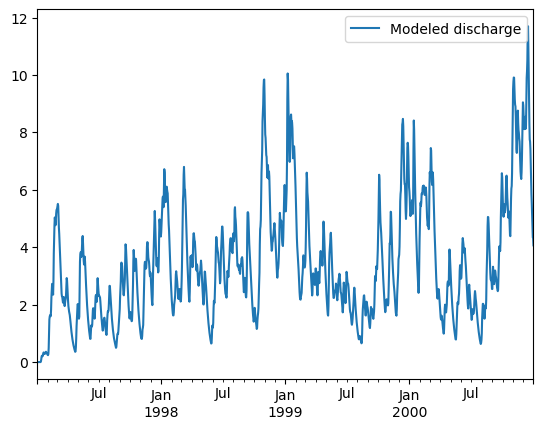

In [31]:
fig, ax = plt.subplots(1,1)
modelOutput.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.legend(bbox_to_anchor=(1,1));

In [32]:
hydro_data = pd.concat([modelOutput.reindex(caravan_observation_df.index, method = 'ffill'), caravan_observation_df], axis=1)


<Axes: xlabel='time'>

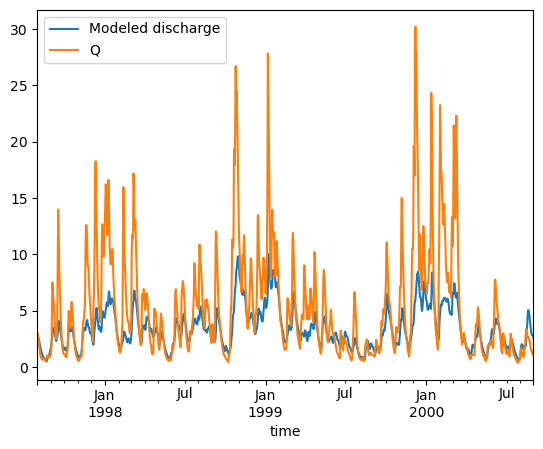

In [33]:
hydro_data.plot()